# Ridge Regression


Importing libraries

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10

Defining input array with angles between 70 deg and 310 deg converted in radians

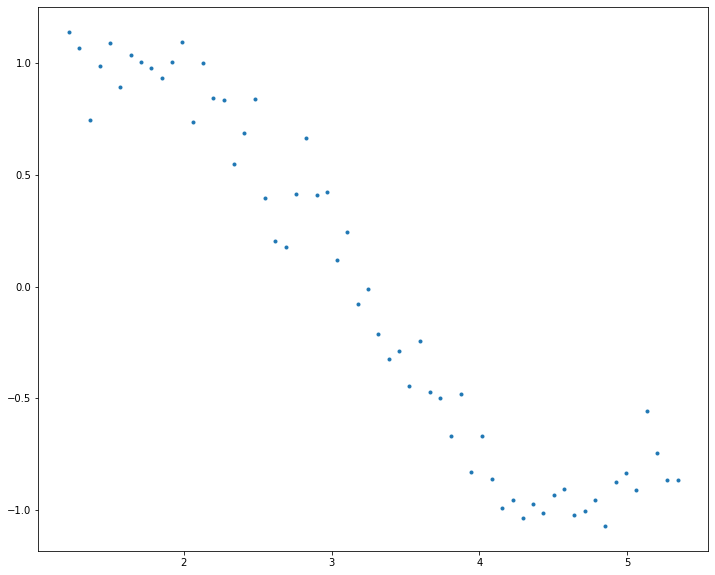

In [4]:

x = np.array([i*np.pi/180 for i in range(70,310,4)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

This resembles a sine curve but not exactly because of the noise. We’ll use this as an example to test different scenarios in this article. Let’s try to estimate the sine function using polynomial regression with powers of x from 1 to 15. Let’s add a column for each power upto 15 in our dataframe. This can be accomplished using the following code:

In [5]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2  ...        x_13        x_14        x_15
0  1.221730  1.139431  1.492625  ...   13.510776   16.506527   20.166527
1  1.291544  1.068554  1.668085  ...   27.823908   35.935792   46.412644
2  1.361357  0.746338  1.853292  ...   55.161442   75.094406  102.230281
3  1.431170  0.989010  2.048248  ...  105.678310  151.243626  216.455338
4  1.500983  1.090764  2.252950  ...  196.284337  294.619483  442.218882

[5 rows x 16 columns]


Now that we have all the 15 powers, let’s make 15 different linear regression models with each model containing variables with powers of x from 1 to the particular model number. For example, the feature set of model 8 will be – {x, x_2, x_3, … ,x_8}.

First, we’ll define a generic function which takes in the required maximum power of x as an input and returns a list containing – [ model RSS, intercept, coef_x, coef_x2, … upto entered power ]. Here RSS refers to ‘Residual Sum of Squares’ which is nothing but the sum of square of errors between the predicted and actual values in the training data set. The python code defining the function is:

In [6]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Note that this function will not plot the model fit for all the powers but will return the RSS and coefficients for all the models.
Now, we can make all 15 models and compare the results. For ease of analysis, we’ll store all the results in a Pandas dataframe and plot 6 models to get an idea of the trend. Consider the following code

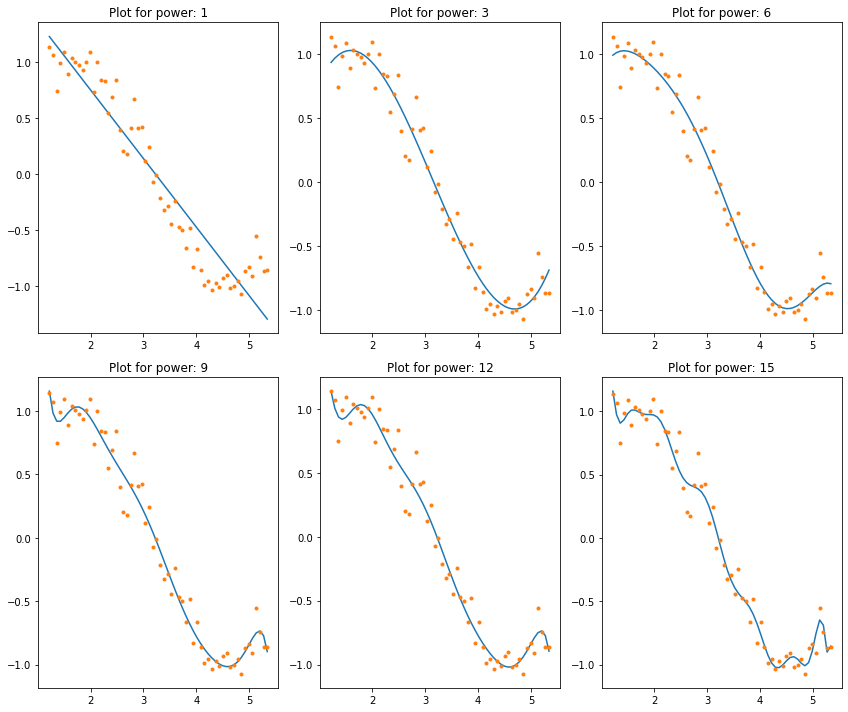

In [7]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

As the model complexity increases, the models tends to fit even smaller deviations in the training data set. Though this leads to overfitting, lets keep this issue aside for some time and come to our main objective, i.e. the impact on the magnitude of coefficients. This can be analysed by looking at the data frame created above.

In [9]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple.head

<bound method NDFrame.head of               rss intercept coef_x_1  ... coef_x_13 coef_x_14 coef_x_15
model_pow_1   3.6         2    -0.61  ...       NaN       NaN       NaN
model_pow_2   3.2       2.5    -0.99  ...       NaN       NaN       NaN
model_pow_3   1.1      -1.1      3.1  ...       NaN       NaN       NaN
model_pow_4   1.1     -0.51      2.1  ...       NaN       NaN       NaN
model_pow_5     1       4.1     -6.7  ...       NaN       NaN       NaN
model_pow_6  0.99      -4.6       13  ...       NaN       NaN       NaN
model_pow_7  0.93        32      -85  ...       NaN       NaN       NaN
model_pow_8  0.92        74 -2.1e+02  ...       NaN       NaN       NaN
model_pow_9  0.87   3.1e+02   -1e+03  ...       NaN       NaN       NaN
model_pow_10 0.87   2.5e+02   -8e+02  ...       NaN       NaN       NaN
model_pow_11 0.87  -2.2e+02  1.2e+03  ...       NaN       NaN       NaN
model_pow_12 0.87  -8.4e+02  4.1e+03  ...       NaN       NaN       NaN
model_pow_13 0.86   8.1e+03 -4.1e+

As mentioned before, ridge regression performs ‘L2 regularization‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. Thus, ridge regression optimizes the following:

**Objective = RSS + α * (sum of square of coefficients)**

Here, **α (alpha)** is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values:

**α = 0:**

1. The objective becomes same as simple linear regression.
2. We’ll get the same coefficients as simple linear regression.

**α = ∞:**

1. The coefficients will be zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.

**0 < α < ∞:**

1. The magnitude of α will decide the weightage given to different parts of objective.
2. The coefficients will be somewhere between 0 and ones for simple linear regression.

In [10]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

Note the ‘Ridge’ function used here. It takes ‘alpha’ as a parameter on initialization. Also, keep in mind that normalizing the inputs is generally a good idea in every type of regression and should be used in case of ridge regression as well.

Now, lets analyze the result of Ridge regression for 10 different values of α ranging from 1e-15 to 20. These values have been chosen so that we can easily analyze the trend with change in values of α. These would however differ from case to case.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.29462e-17): result may not be accurate.
  overwrite_a=True).T


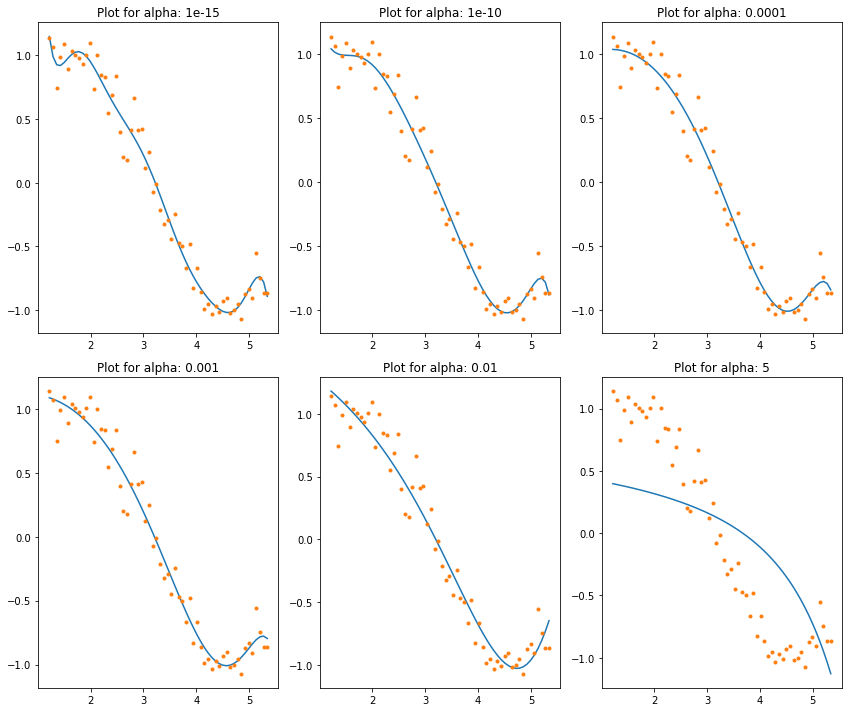

In [11]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Here we can clearly observe that **as the value of alpha increases, the model complexity reduces.** Though higher values of alpha reduce overfitting, significantly high values can cause underfitting as well (eg. alpha = 5). Thus alpha should be chosen wisely. A widely accept technique is cross-validation, i.e. the value of alpha is iterated over a range of values and the one giving higher cross-validation score is chosen.

In [14]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
print(coef_matrix_ridge)

coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

              rss intercept coef_x_1  ... coef_x_13 coef_x_14 coef_x_15
alpha_1e-15  0.87   1.7e+02 -4.8e+02  ...  -1.3e-05    -9e-07   1.1e-07
alpha_1e-10  0.93        14      -31  ...   5.8e-08   1.2e-07  -1.1e-08
alpha_1e-08  0.95       1.7     -1.8  ...   5.5e-09     5e-10  -3.7e-10
alpha_0.0001 0.96      0.79     0.38  ...  -7.4e-11  -9.7e-11  -3.8e-11
alpha_0.001     1       1.1     0.14  ...  -9.6e-11  -8.6e-11  -3.1e-11
alpha_0.01    1.3       1.5    -0.21  ...   1.4e-11  -2.2e-11  -9.3e-12
alpha_1       6.2      0.95    -0.15  ...   4.8e-11   1.1e-11   2.2e-12
alpha_5        15      0.49   -0.061  ...  -7.9e-12  -9.1e-13  -7.3e-14
alpha_10       19      0.33   -0.038  ...  -1.5e-11  -2.5e-12  -4.2e-13
alpha_20       24       0.2   -0.023  ...  -1.4e-11  -2.5e-12  -4.4e-13

[10 rows x 17 columns]


alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
alpha_20        0
dtype: int64

This confirms that all the 15 coefficients are greater than zero in magnitude (can be +ve or -ve). Remember this observation and have a look again until its clear. This will play an important role in later while comparing ridge with lasso regression.